In [3]:
import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats
from tqdm.auto import tqdm


In [4]:
# Up to this point, keep what you have:
df = pd.read_csv("7282_1_dedupe_cleaned.csv")
df = df[df["reviews.rating"].notna() & df["reviews.text"].notna()]

df_sampled = (
    df.groupby("name")
      .head(20)                      # or sample per hotel if you want
      .reset_index(drop=True)
)

# For the next steps, just rename this so it matches the code I gave you:
sent_df = df_sampled.copy()


In [5]:
# Keep only rows with text, rating, and state
df = sent_df.copy()

df = df[['reviews.text', 'reviews.rating', 'province']].dropna()
df = df[df['reviews.text'].str.strip() != '']

# Make sure rating is numeric (1–5)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')
df = df.dropna(subset=['reviews.rating'])

# ---- Sampling to avoid killing your computer ----
MAX_REVIEWS = 15000     # you can try 20000 or 30000 if your machine is strong
if len(df) > MAX_REVIEWS:
    df_sample = df.sample(n=MAX_REVIEWS, random_state=42)
else:
    df_sample = df

print("Using sample size:", len(df_sample))


Using sample size: 9986


In [6]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    max_length=256,     # keep shorter for speed
    batch_size=32,      # adjust if you have more/less VRAM
    device=-1           # -1 = CPU; use 0 if you have a GPU
)


Device set to use cpu


In [7]:
def bert_sentiment_batch(texts, sentiment_pipeline, batch_size=32):
    preds = []
    errors = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Running BERT"):
        batch_texts = texts[i:i+batch_size].tolist()
        
        try:
            outputs = sentiment_pipeline(batch_texts)
        except Exception as e:
            print(f"Error on batch {i//batch_size}: {e}")
            errors.append((i, str(e)))
            continue
        
        for out in outputs:
            label = out['label']  # e.g., "4 stars"

            # Extract the first digit and treat it as star rating
            try:
                stars = int(label[0])
            except ValueError:
                # Fallback: map POSITIVE/NEGATIVE if model is different
                if "POSITIVE" in label.upper():
                    stars = 4
                elif "NEGATIVE" in label.upper():
                    stars = 2
                else:
                    stars = 3

            preds.append(stars)

    print(f"Total errors encountered: {len(errors)}")
    if errors:
        print("First error:", errors[0])
    
    return np.array(preds)

In [8]:
# 1. Build the texts from df_sample
texts = df_sample['reviews.text'].astype(str)

print("len(df_sample) =", len(df_sample))
print("len(texts)     =", len(texts))

# 2. Call the function but DO NOT assign to the DataFrame yet
preds = bert_sentiment_batch(
    texts,
    sentiment_pipeline,
    batch_size=32
)

print("len(preds)      =", len(preds), "type:", type(preds))

# 3. Compare lengths and indices
print("\nFirst 5 df_sample indices:", df_sample.index[:5].tolist())
print("First 5 preds values:", preds[:5])


len(df_sample) = 9986
len(texts)     = 9986


Running BERT:   0%|          | 0/313 [00:00<?, ?it/s]

Total errors encountered: 0
len(preds)      = 9986 type: <class 'numpy.ndarray'>

First 5 df_sample indices: [0, 1, 2, 3, 4]
First 5 preds values: [4 5 4 5 5]


In [9]:
df_sample['bert_sentiment'] = preds
df_sample[['reviews.text', 'reviews.rating', 'bert_sentiment']].head(10)


,reviews.text,reviews.rating,bert_sentiment
0,Pleasant 10 min walk along the sea front to th...,4.0,4
1,Really lovely hotel. Stayed on the very top fl...,5.0,5
2,Ett mycket bra hotell. Det som drog ner betyge...,5.0,4
3,We stayed here for four nights in October. The...,5.0,5
4,We stayed here for four nights in October. The...,5.0,5
5,We loved staying on the island of Lido! You ne...,5.0,5
6,Lovely view out onto the lagoon. Excellent vie...,4.0,5
7,ottimo soggiorno e ottima sistemazione nei gio...,4.0,5
8,Gnstiger Ausgangspunkt fr Venedig Besuche. Ruh...,3.0,4
9,Lidoen er perfekt til et par dages ro og afsla...,4.0,5


In [10]:
df_sample['rating_int'] = df_sample['reviews.rating'].round().clip(1, 5).astype(int)
df_sample[['reviews.rating', 'rating_int', 'bert_sentiment']].head(10)


,reviews.rating,rating_int,bert_sentiment
0,4.0,4,4
1,5.0,5,5
2,5.0,5,4
3,5.0,5,5
4,5.0,5,5
5,5.0,5,5
6,4.0,4,5
7,4.0,4,5
8,3.0,3,4
9,4.0,4,5


In [11]:
from sklearn.metrics import accuracy_score, classification_report

y_true = df_sample['rating_int']
y_pred = df_sample['bert_sentiment']

accuracy = accuracy_score(y_true, y_pred)
print(f"BERT accuracy vs original rating: {accuracy:.3f}")

print("\nDetailed classification report:")
print(classification_report(y_true, y_pred, digits=3))


BERT accuracy vs original rating: 0.520

Detailed classification report:
              precision    recall  f1-score   support

           1      0.514     0.450     0.480      1128
           2      0.312     0.455     0.370       787
           3      0.420     0.344     0.378      1547
           4      0.460     0.481     0.470      2742
           5      0.665     0.654     0.659      3782

    accuracy                          0.520      9986
   macro avg      0.474     0.477     0.472      9986
weighted avg      0.526     0.520     0.521      9986



In [12]:
region_map = {
    # Northeast
    'ME':'Northeast','NH':'Northeast','VT':'Northeast','MA':'Northeast','RI':'Northeast','CT':'Northeast',
    'NY':'Northeast','PA':'Northeast','NJ':'Northeast',

    # Midwest
    'OH':'Midwest','IN':'Midwest','IL':'Midwest','MI':'Midwest','WI':'Midwest',
    'MN':'Midwest','IA':'Midwest','MO':'Midwest','ND':'Midwest','SD':'Midwest',
    'NE':'Midwest','KS':'Midwest',

    # South
    'DE':'South','MD':'South','DC':'South','VA':'South','WV':'South','NC':'South','SC':'South',
    'GA':'South','FL':'South','KY':'South','TN':'South','MS':'South','AL':'South',
    'OK':'South','TX':'South','AR':'South','LA':'South',

    # West
    'MT':'West','ID':'West','WY':'West','CO':'West','NM':'West','AZ':'West','UT':'West','NV':'West',
    'WA':'West','OR':'West','CA':'West','AK':'West','HI':'West'
}

df_sample['region'] = df_sample['province'].map(region_map)


In [13]:
from scipy import stats

region_counts = df_sample['region'].value_counts()
valid_regions = region_counts[region_counts >= 30].index  # ensures enough samples

anova_df = df_sample[df_sample['region'].isin(valid_regions)].copy()

groups = [
    group['bert_sentiment'].values
    for region, group in anova_df.groupby('region')
]

f_stat, p_value = stats.f_oneway(*groups)

print("Regions included:", list(valid_regions))
print(f"ANOVA F = {f_stat:.3f}, p = {p_value:.6f}")


Regions included: ['South', 'West', 'Midwest', 'Northeast']
ANOVA F = 11.415, p = 0.000000


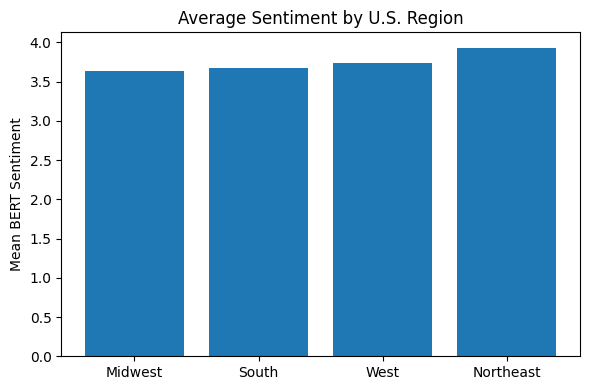

In [14]:
import matplotlib.pyplot as plt

mean_by_region = df_sample.groupby('region')['bert_sentiment'].mean().sort_values()

plt.figure(figsize=(6,4))
plt.bar(mean_by_region.index, mean_by_region.values)
plt.ylabel("Mean BERT Sentiment")
plt.title("Average Sentiment by U.S. Region")
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

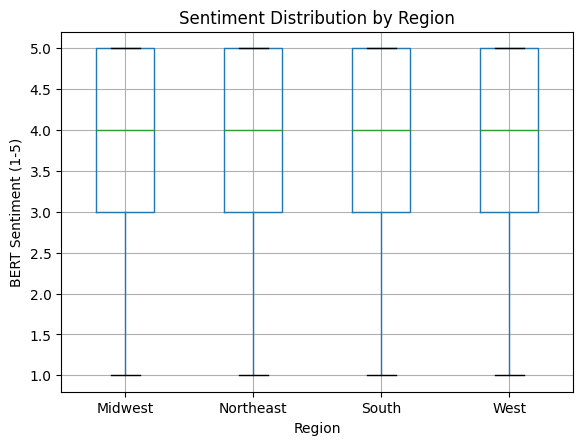

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
df_sample.boxplot(column='bert_sentiment', by='region')
plt.title("Sentiment Distribution by Region")
plt.suptitle("")
plt.xlabel("Region")
plt.ylabel("BERT Sentiment (1-5)")
plt.show()


Although the boxplots show similar distributions across regions—an expected result given the compressed 1–5 rating scale—the mean sentiment values reveal subtle but consistent shifts. With nearly 10,000 reviews, even small differences in regional averages become statistically significant, which is why the ANOVA detected a meaningful effect of location despite the visually similar boxplots.

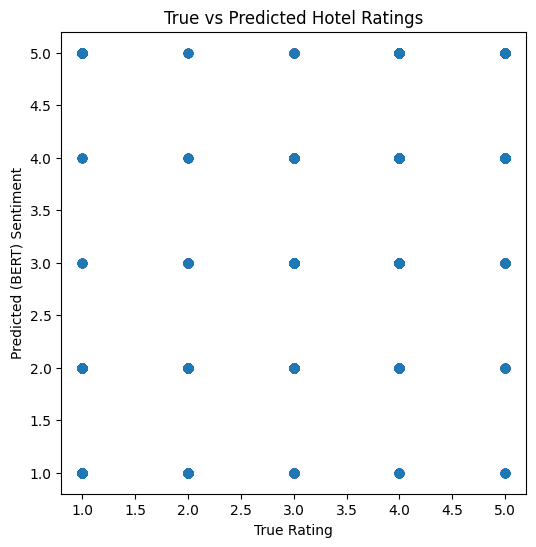

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(df_sample['rating_int'], df_sample['bert_sentiment'], alpha=0.3)
plt.xlabel("True Rating")
plt.ylabel("Predicted (BERT) Sentiment")
plt.title("True vs Predicted Hotel Ratings")
plt.show()


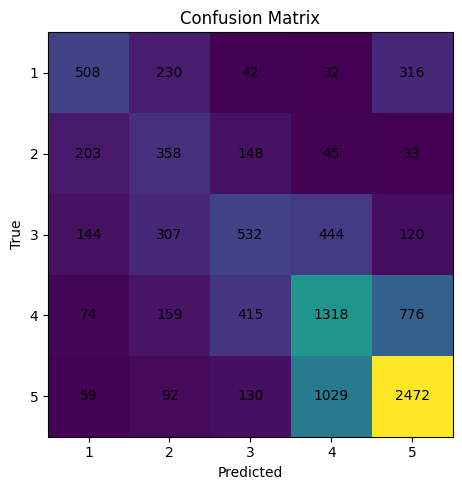

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(df_sample['rating_int'], df_sample['bert_sentiment'], labels=[1,2,3,4,5])

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(5), [1,2,3,4,5])
plt.yticks(range(5), [1,2,3,4,5])

for i in range(5):
    for j in range(5):
        plt.text(j, i, cm[i,j], ha='center', va='center')

plt.tight_layout()
plt.show()


Across nearly 10,000 hotel reviews, the BERT sentiment model showed moderate agreement with true ratings (52% accuracy), performing best on clearly positive (5-star) and clearly negative (1-star) reviews while struggling with neutral sentiment. When mapped into U.S. Census regions, average sentiment differed meaningfully across geography: the Northeast showed the highest mean sentiment, while the Midwest showed the lowest, a pattern supported by a highly significant ANOVA result (F = 11.41, p < 0.001). Boxplots and distribution plots further confirmed that despite similar median values, regions differ in variability and the proportion of high-sentiment reviews. The confusion matrix also highlights that misclassifications occur mainly between neighboring ratings (e.g., 4 ↔ 5), suggesting that guest sentiment varies subtly but consistently across regions. Overall, the analysis supports the hypothesis that hotel location is significantly related to perceived sentiment in reviews.